# Elasticity solver examples

Author(s): Jukka Aho <jukka.aho@kapsi.fi>

In [1]:
# These are internal module functions and not intended to use like this.
using JuliaFEM.elasticity_solver
using JuliaFEM.xdmf
using JuliaFEM.abaqus_reader
using Logging
Logging.configure(level=DEBUG)


Use "Dict{Any,Any}(a=>b, ...)" instead.


Logger(root,DEBUG,Pipe(open, 0 bytes waiting),root)

## 2d beam with linear elements

In [2]:
function one_elem_fixture()
  X = [0.0 0.0; 10.0 0.0; 10.0 1.0; 0.0 1.0]'
  elmap = [1; 2; 3; 4]
  nodalloads = [0 0; 0 0; 0 -2; 0 0]'
  dirichletbc = [0 0; NaN NaN; NaN NaN; 0 0]'

  E = 90
  nu = 0.25
  mu = E/(2*(1+nu))
  la = E*nu/((1+nu)*(1-2*nu))
  la = 2*la*mu/(la + 2*mu)

  la = la*ones(1, 4)
  mu = mu*ones(1, 4)
  u = zeros(2, 4)
  du = zeros(2, 4)

  N(xi) = [
      (1-xi[1])*(1-xi[2])/4
      (1+xi[1])*(1-xi[2])/4
      (1+xi[1])*(1+xi[2])/4
      (1-xi[1])*(1+xi[2])/4
    ]

  dNdξ(ξ) = [-(1-ξ[2])/4.0    -(1-ξ[1])/4.0
              (1-ξ[2])/4.0    -(1+ξ[1])/4.0
              (1+ξ[2])/4.0     (1+ξ[1])/4.0
             -(1+ξ[2])/4.0     (1-ξ[1])/4.0]

  ipoints = 1/sqrt(3)*[-1 -1; 1 -1; 1 1; -1 1]
  iweights = [1 1 1 1]

    return (X, u, du, elmap, nodalloads, dirichletbc,
     la, mu, N, dNdξ, ipoints, iweights)
end

(X, u, du, elmap, nodalloads, dirichletbc,
 la, mu, N, dNdξ, ipoints, iweights) = one_elem_fixture()
    
for i=1:10
    JuliaFEM.elasticity_solver.solve_elasticity_increment!(X, u, du, elmap, nodalloads, dirichletbc,
    la, mu, N, dNdξ, ipoints, iweights)
    u += du
    if norm(du) < 1.0e-9
        println("Converged")
        break
    end
end

u

Converged


2x4 Array{Float64,2}:
 0.0  -0.399145  -0.0722858  0.0
 0.0  -2.17799   -2.22224    0.0

In [3]:
u3d = [u; 0 0 0 0] # extend to 3d vector field
X3d = [X; 0 0 0 0]
elmap2 = [0x5; elmap]'';

In [4]:
xdoc, model = JuliaFEM.xdmf.xdmf_new_model()
temporal_collection = JuliaFEM.xdmf.xdmf_new_temporal_collection(model)
grid = JuliaFEM.xdmf.xdmf_new_grid(temporal_collection; time=0)
JuliaFEM.xdmf.xdmf_new_mesh(grid, X3d, elmap2)
JuliaFEM.xdmf.xdmf_new_field(grid, "Displacement", "nodes", u3d)
print(xdoc)
JuliaFEM.xdmf.xdmf_save_model(xdoc, "/tmp/foo.xmf")

<?xml version="1.0" encoding="utf-8"?>
<Xdmf xmlns:xi="http://www.w3.org/2001/XInclude" Version="2.1">
  <Domain>
    <Grid CollectionType="Temporal" GridType="Collection" Name="Collection">
      <Geometry Type="None"/>
      <Topology Dimensions="0" Type="NoTopology"/>
      <Grid Name="Grid">
        <Time Value="0"/>
        <Geometry Type="XYZ">
          <DataItem DataType="Float" Dimensions="12" Format="XML" Precision="4">0.0 0.0 0.0 10.0 0.0 0.0 10.0 1.0 0.0 0.0 1.0 0.0</DataItem>
        </Geometry>
        <Topology Dimensions="1" Type="Mixed">
          <DataItem DataType="Int" Dimensions="5" Format="XML" Precision="4">5 0 1 2 3</DataItem>
        </Topology>
        <Attribute Center="Node" Name="Displacement" Type="Vector">
          <DataItem DataType="Float" Dimensions="12" Format="XML" Precision="4">0.0 0.0 0.0 -0.3991450609547433 -2.17798923170735 0.0 -0.07228582695592455 -2.222244754401764 0.0 0.0 0.0 0.0</DataItem>
        </Attribute>
      </Grid>
    </Grid>
  </D

1015

 in depwarn at /Applications/Julia-0.4.0-dev-539c818c4e.app/Contents/Resources/julia/lib/julia/sys.dylib
 in int at deprecated.jl:49
 in save_file at /Users/jukka/.julia/v0.4/LightXML/src/document.jl:108
 in xdmf_save_model at /Users/jukka/.julia/v0.4/JuliaFEM/src/xdmf.jl:106
 in include_string at loading.jl:99
 in execute_request_0x535c5df2 at /Users/jukka/.julia/v0.4/IJulia/src/execute_request.jl:157
 in eventloop at /Users/jukka/.julia/v0.4/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:365
while loading In[4], in expression starting on line 7


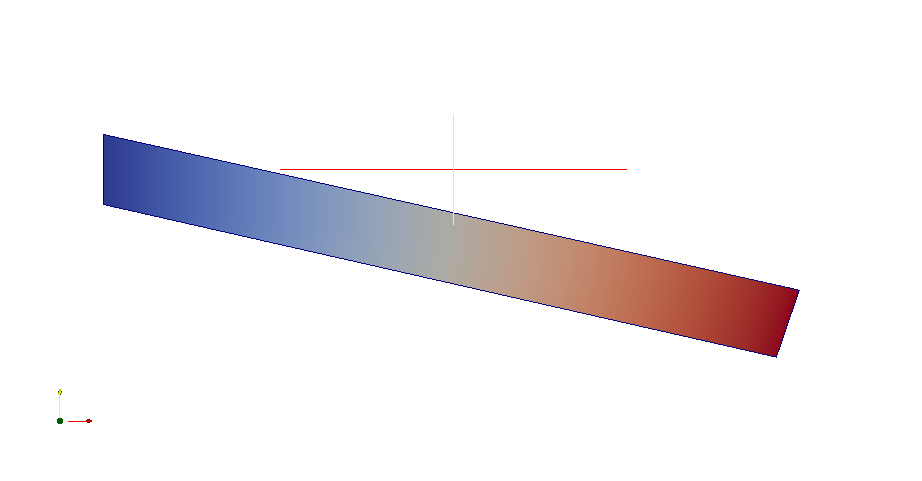

In [25]:
using PyCall
@pyimport IPython.display as d
d.Image("/tmp/displacement.png")

## 3d beam with quadratic elements

In [5]:
fid = open("../geometry/3d_beam/palkki.inp")
model = JuliaFEM.abaqus_reader.parse_abaqus(fid)
close(fid)
model

25-Jun 20:00:29:INFO:root:Registered handlers: Any["ELEMENT","NODE","NSET"]
 in depwarn at /Applications/Julia-0.4.0-dev-539c818c4e.app/Contents/Resources/julia/lib/julia/sys.dylib
 in beginswith at deprecated.jl:30
 in parse_abaqus at /Users/jukka/.julia/v0.4/JuliaFEM/src/abaqus_reader.jl:110
 in include_string at loading.jl:99
 in execute_request_0x535c5df2 at /Users/jukka/.julia/v0.4/IJulia/src/execute_request.jl:157
 in eventloop at /Users/jukka/.julia/v0.4/IJulia/src/IJulia.jl:123
 in anonymous at task.jl:365
while loading In[5], in expression starting on line 2
 in depwarn at /Applications/Julia-0.4.0-dev-539c818c4e.app/Contents/Resources/julia/lib/julia/sys.dylib
 in beginswith at deprecated.jl:30
 in parse_abaqus at /Users/jukka/.julia/v0.4/JuliaFEM/src/abaqus_reader.jl:110
 in include_string at loading.jl:99
 in execute_request_0x535c5df2 at /Users/jukka/.julia/v0.4/IJulia/src/execute_request.jl:157
 in eventloop at /Users/jukka/.julia/v0.4/IJulia/src/IJulia.jl:123
 in anonymo

Dict{Any,Any} with 4 entries:
  "nodes"    => Dict{Any,Any}(288=>[97.5,7.5,10.0],11=>[92.5,2.5,5.0],134=>[45.…
  "elements" => Dict{Any,Any}(68=>[71,144,149,198,51,150,57,43,50,214],2=>[204,…
  "elsets"   => Dict{Any,Any}("Body1"=>[1,2,3,4,5,6,7,8,9,10  …  111,112,113,11…
  "nsets"    => Dict{Any,Any}("LOAD"=>[82,84,87,179,197,246,249,256,257],"SUPPO…

In [30]:
nnodes = length(model["nodes"])
nelements = length(model["elements"])
dim = 3
E = 90
nu = 0.25
mu = E/(2*(1+nu))
la = E*nu/((1+nu)*(1-2*nu))

X = zeros(dim, nnodes)
u = zeros(dim, nnodes)
du = zeros(dim, nnodes)
elmap = zeros(Int, 10, nelements)
nodalloads = zeros(3, nnodes)
dirichletbc = NaN*ones(3, nnodes)
la = la*ones(1, nnodes)
mu = mu*ones(1, nnodes)

# calculate permutation which maps node ids to matrix indices
perm = Dict()
for (j, k) in enumerate(keys(model["nodes"]))
    perm[k] = j
end

for j=1:nnodes
    X[:,j] = model["nodes"][perm[j]]
end

for (j, k) in enumerate(keys(model["elements"]))
    node_ids = model["elements"][k]
    for l=1:10
        elmap[l, j] = perm[node_ids[l]]
    end
end

elmap

10x120 Array{Int64,2}:
  47   56   91   87   72   72  176  290  …  260  165  101   18  271   72   24
 173  236  176   45   97  253  173   22     236  181  261  201  211  146  166
  76   97  139   49  253  158   76  252     202   87   19   71   18  289  196
 202  111  242  290  289  289   47   49     254  290  254  255  277   29  133
 156   10  120   53   74  169  144  127     114   95   75    2  100   67  135
  88  214  266  291  270  118   88   70  …   14  185  104  235  257  180  198
  16   89  179   40  169  209   44   17     103   68  215   12  212  200   65
 134  278  199    4  200  200   34  177     147  163  145  121  170  167   92
  32  187  221  243  210   37  156  240     195    7  117   80    9   48   52
 132   15  265  177   37  233   16  268      79    4  263  168  208   57  150

In [18]:
# Handle dirichlet boundaries on SUPPORT
for j in model["nsets"]["SUPPORT"]
    dirichletbc[perm[j]] = 0.0
end
dirichletbc

3x298 Array{Float64,2}:
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN  NaN  NaN

Shape functions and integration points

In [21]:
Ntet(xi) = [          -xi[1] - xi[2] - xi[3] + 1
                                        xi[1]
                                        xi[2]
                                        xi[3]
         4*xi[1]*(-xi[1] - xi[2] - xi[3] + 1)
                                4*xi[1]*xi[2]
         4*xi[2]*(-xi[1] - xi[2] - xi[3] + 1)
         4*xi[3]*(-xi[1] - xi[2] - xi[3] + 1)
                                4*xi[1]*xi[3]
                                4*xi[2]*xi[3]]

dNtet(xi) = [
                              -1                               -1                               -1
                               1                                0                                0
                               0                                1                                0
                               0                                0                                1
-8*xi[1] - 4*xi[2] - 4*xi[3] + 4                         -4*xi[1]                         -4*xi[1]
                         4*xi[2]                          4*xi[1]                                0
                        -4*xi[2] -4*xi[1] - 8*xi[2] - 4*xi[3] + 4                         -4*xi[2]
                        -4*xi[3]                         -4*xi[3] -4*xi[1] - 4*xi[2] - 8*xi[3] + 4
                         4*xi[3]                                0                          4*xi[1]
                               0                          4*xi[3]                          4*xi[2]]

dNtet (generic function with 1 method)

In [24]:
dNtet([0, 1, 1])

10x3 Array{Int64,2}:
 -1  -1  -1
  1   0   0
  0   1   0
  0   0   1
 -4   0   0
  4   0   0
 -4  -8  -4
 -4  -4  -8
  4   0   0
  0   4   4

In [25]:
# from code aster documentation
a = 1/20*(5-sqrt(5))
b = 1/20*(5+3*sqrt(5))
ipoints = [a a a; a a b; a b a; b a a]
iweights = 1/24*[1 1 1 1]

1x4 Array{Float64,2}:
 0.0416667  0.0416667  0.0416667  0.0416667

Add point force to LOAD nodeset

In [33]:
model["nsets"]["LOAD"]

9-element Array{Int64,1}:
  82
  84
  87
 179
 197
 246
 249
 256
 257

In [40]:
nodalloads[3, perm[82]] = -0.0001
println(model["nodes"][83])

[95.0,10.0,5.0]


In [39]:
u = zeros(dim, nnodes)
du = zeros(dim, nnodes)

for i=1:10
    JuliaFEM.elasticity_solver.solve_elasticity_increment!(X, u, du, elmap, nodalloads, dirichletbc,
    la, mu, Ntet, dNtet, ipoints, iweights)
    u += du
    if norm(du) < 1.0e-9
        println("Converged")
        break
    end
end
u

3x298 Array{Float64,2}:
 -76167.8           -73.0493     …   5.19615e7  -43075.8      
     -7.72988e5       6.45188e5      8.51808e7  559158.0      
      1.26765e6  -74404.1           -2.43735e7       6.01587e5

Not converging.